# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя  

Целевой признак
- Price — цена (евро)

## Подготовка данных

In [1]:
!pip install lightgbm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import re
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [3]:
warnings.simplefilter(action='ignore')
%matplotlib inline

In [4]:
pth1 = 'autos.csv'
pth2 = '/datasets/autos.csv'
    
if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [5]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Приведем названия столбцов к стилю snake_case

In [7]:
snake_case_columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower() for col in df.columns]
snake_case_columns

['date_crawled',
 'price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'registration_month',
 'fuel_type',
 'brand',
 'not_repaired',
 'date_created',
 'number_of_pictures',
 'postal_code',
 'last_seen']

In [8]:
df.columns = snake_case_columns

Проверим наличие дубликатов и удалим их

In [9]:
df.duplicated().sum()

4

In [10]:
df.drop_duplicates(inplace=True)

Рассчитаем количество пропущенных значений в каждом столбце и их долю в общем объеме датасета.

In [11]:
df.isna().agg(['sum', 'mean']).T

,sum,mean
date_crawled,0.0,0.000000
price,0.0,0.000000
vehicle_type,37490.0,0.105795
registration_year,0.0,0.000000
gearbox,19833.0,0.055968
power,0.0,0.000000
model,19705.0,0.055607
kilometer,0.0,0.000000
registration_month,0.0,0.000000
fuel_type,32895.0,0.092828


Преобразуем тип данных столбцов с датами и временем в `datetime`

In [12]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'])
df['date_created'] = pd.to_datetime(df['date_created'])
df['last_seen'] = pd.to_datetime(df['last_seen'])

In [13]:
df.describe(include='datetime')

,date_crawled,date_created,last_seen
count,354365,354365,354365
unique,271174,109,179150
top,2016-03-24 14:49:47,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,13718,17
first,2016-03-05 14:06:22,2014-03-10 00:00:00,2016-03-05 14:15:08
last,2016-04-07 14:36:58,2016-04-07 00:00:00,2016-04-07 14:58:51


Анкеты скачаны в период с 05.03 по 07.04 2016 года, созданы в период с марта 2014 года по день скачивания. Данные столбцы не несут какую-либо информацию об автомобиле и могут быть удалены.

Рассмотрим столбцы с числовым типом данных

In [14]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


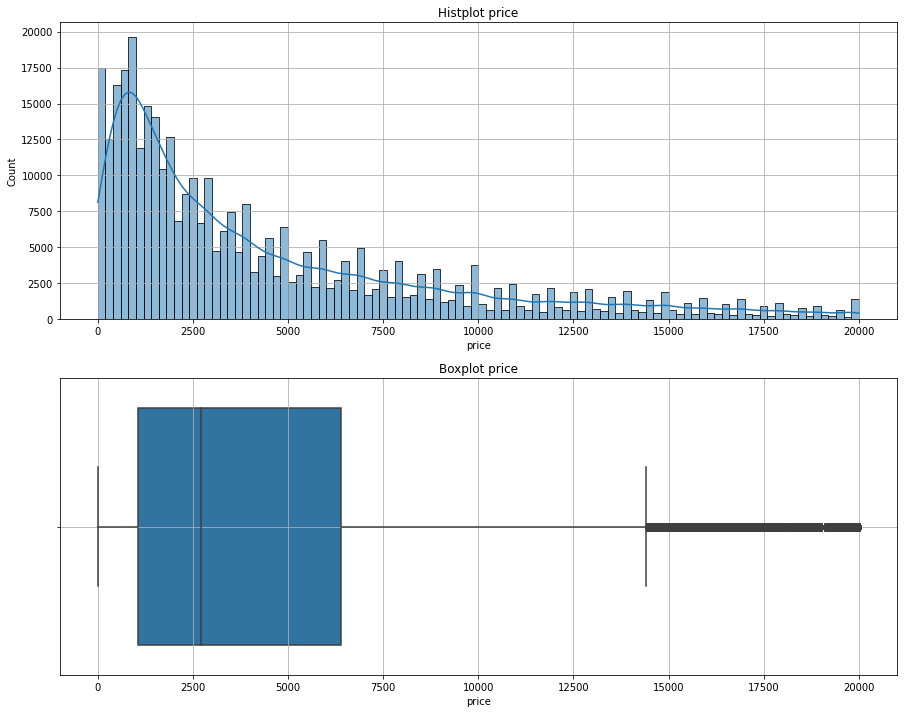

                   count   percent
registration_year                 
2000               24490  6.910953
1999               22727  6.413444
2005               22109  6.239047
2001               20123  5.678608
2006               19900  5.615679
...                  ...       ...
2900                   1  0.000282
3200                   1  0.000282
3500                   1  0.000282
3700                   1  0.000282
1255                   1  0.000282

[151 rows x 2 columns]


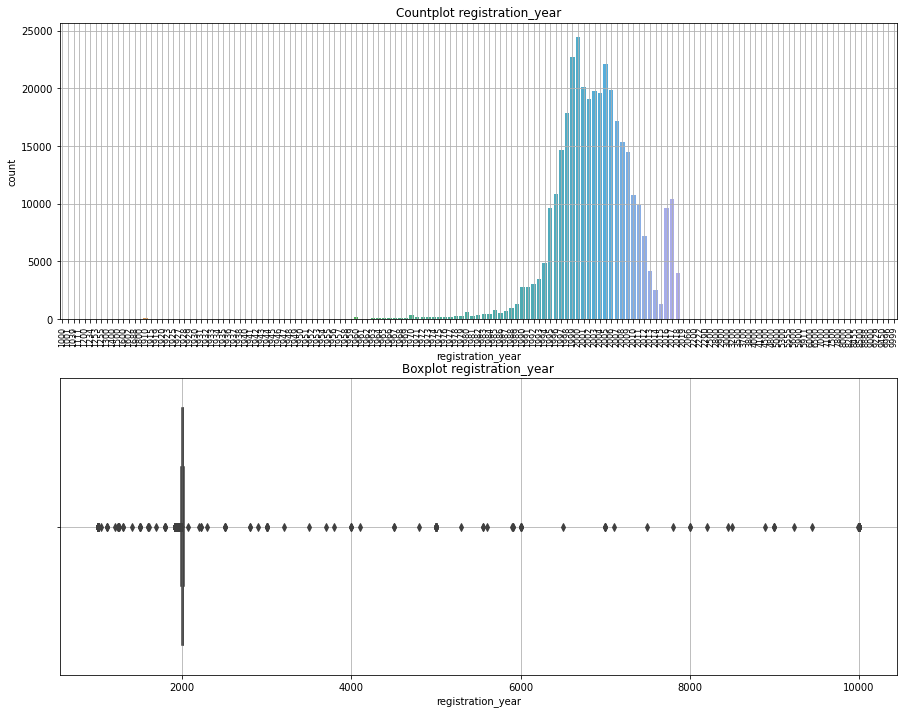

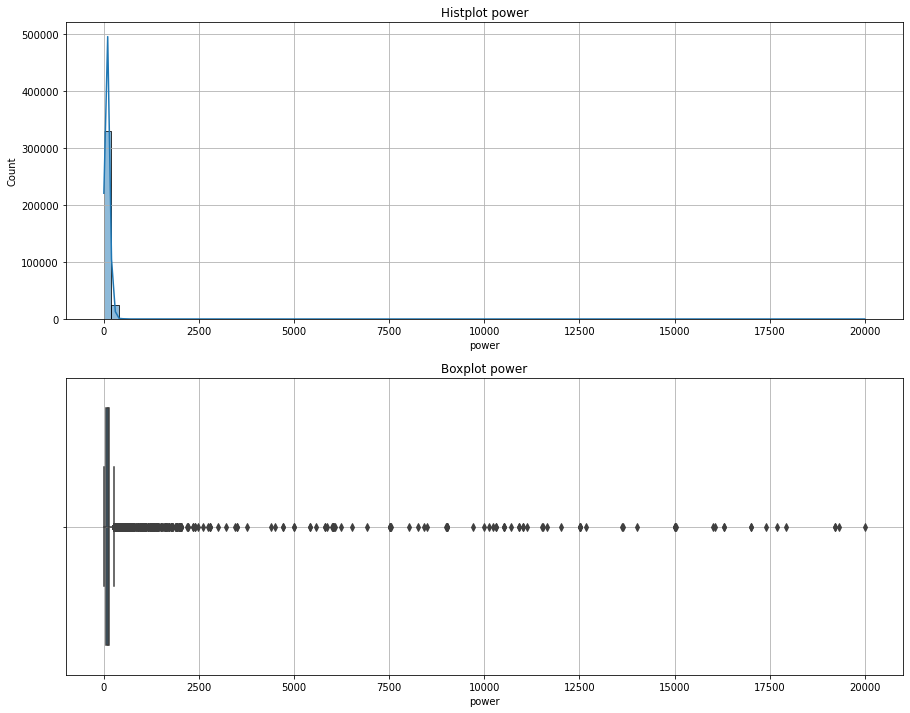

            count    percent
kilometer                   
150000     238207  67.220803
125000      36453  10.286851
100000      14882   4.199625
90000       11567   3.264149
80000       10047   2.835212
70000        8593   2.424901
60000        7444   2.100659
5000         6397   1.805201
50000        6232   1.758639
40000        4911   1.385859
30000        4436   1.251817
20000        3974   1.121443
10000        1222   0.344842


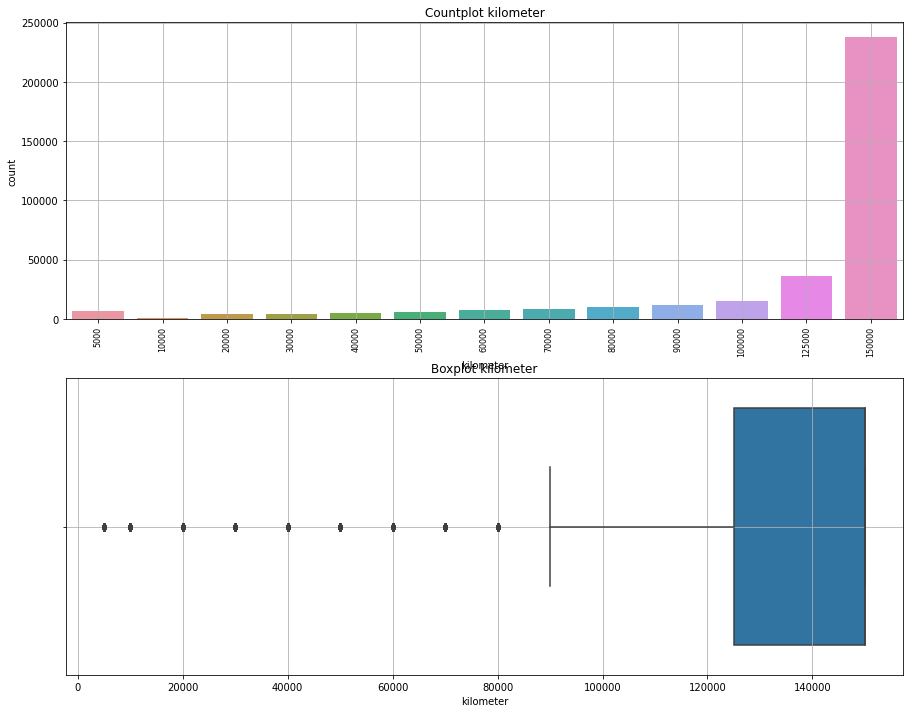

                    count    percent
registration_month                  
0                   37352  10.540544
3                   34373   9.699886
6                   31507   8.891115
4                   29270   8.259845
5                   29153   8.226828
7                   27211   7.678806
10                  26099   7.365005
12                  24289   6.854232
11                  24186   6.825166
9                   23813   6.719907
1                   23218   6.552001
8                   22627   6.385224
2                   21267   6.001439


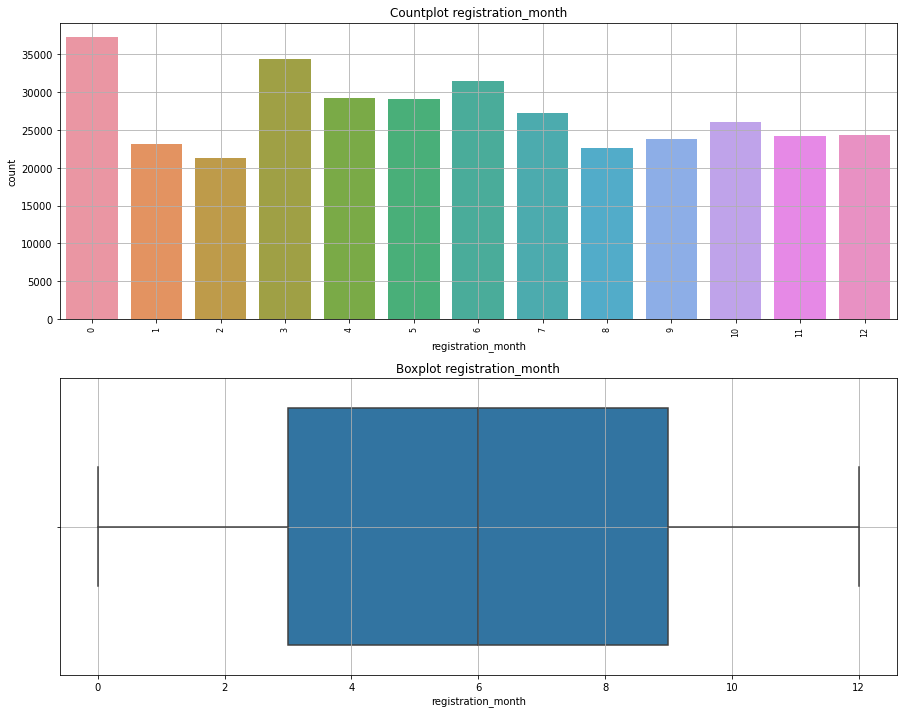

                     count  percent
number_of_pictures                 
0                   354365    100.0


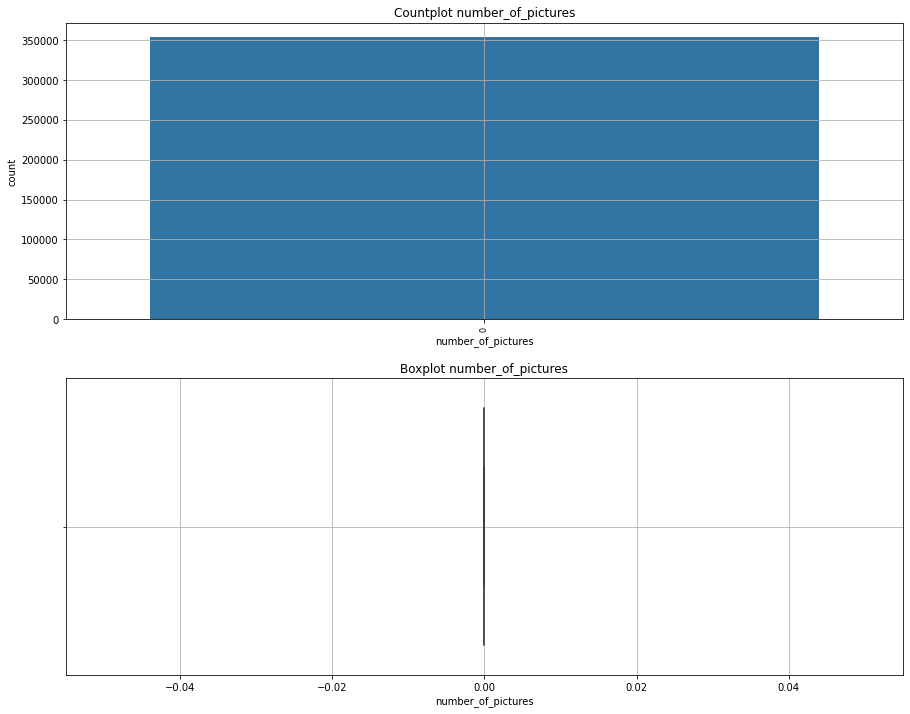

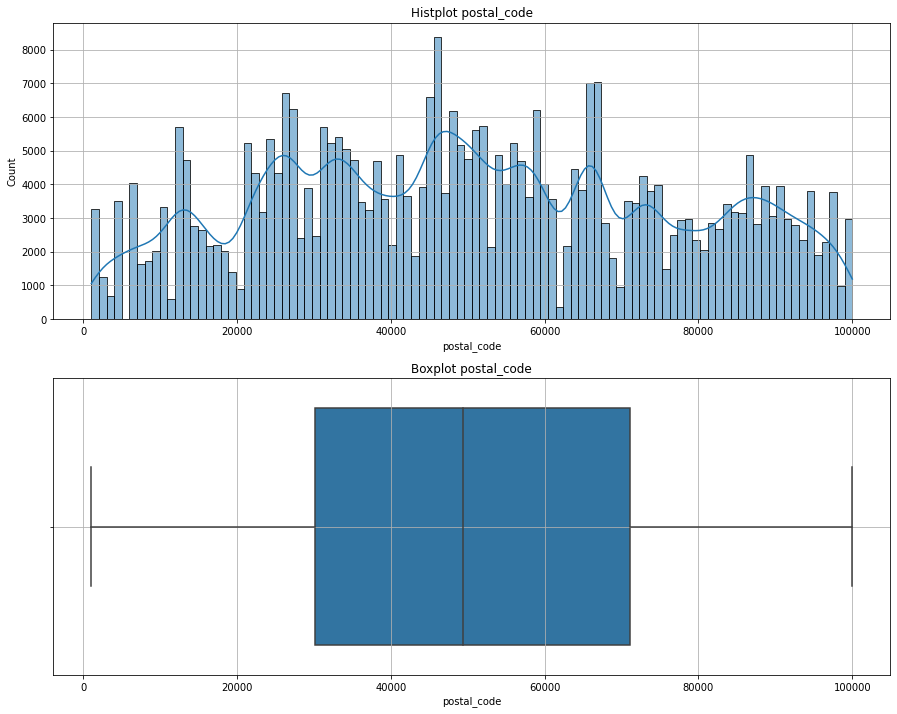

In [15]:
continuous_col = ['price', 'power', 'postal_code']
discrete_col = ['kilometer', 'number_of_pictures', 'registration_year', 'registration_month']

for col in df.select_dtypes(include='number').columns:

    plt.figure(figsize=(15,12))
    plt.subplot(2,1,1)
    if col in continuous_col:
        sns.histplot(data=df[col], kde=True, bins=100)
        plt.grid()
        plt.title('Histplot '+col)
    else:
        print(df.groupby(col)[col].agg(['count']).assign(percent=lambda x: x / x.sum() * 100).
                                    sort_values('count', ascending=False))
        sns.countplot(data=df, x=col)
        plt.grid()
        plt.title('Countplot '+col)
        plt.xticks(rotation=90, fontsize=8)
    plt.subplot(2,1,2)
    sns.boxplot(data=df, x=col)
    plt.grid()
    plt.title('Boxplot '+col)
    
    plt.show()


Цена меняется от нуля до 20 тыс. евро. Медианное значение составляет 2700 евро, среднее - 4416 евро. Вероятно, нулевые значения являются пропусками или ошибками в данных. Данный признак является целевым, от явно ошибочных данных в данном столбце лучше избавиться

In [16]:
# Процент объектов с нулевым значением цены
df[df['price'] == 0]['price'].count() / df.shape[0] * 100

3.0398035923412303

In [17]:
df = df.query('price > 0')

Год регистрации косвенно характеризует возраст автомобиля и, вероятно, является достаточно важным прогностическим признаком.  
В основном продаются машины, зарегистрированные в конце 1990-х и начале 2000-х годов.   
Также отдельный пик на графике образуют автомобили, зарегистрированные в 2016-2018 гг. При этом обращает внимание факт, что даты скачивания всех анкет и дата последнего просмотра датируются 2016 годом. Вероятно, машины, зарегистрированные, позднее 2016 года - это ошибочные данные. 
Кроме того, имеются явно ошибочные данные со значениями менее 1900 (1000 - 1800) и более 2019 (2066 -9999), количество которых невелико.

In [18]:
# Процент объектов с датой регистрации позднее даты скачивания анкеты
df[df['registration_year'] > df['date_crawled'].dt.year]['price'].count() / df.shape[0] * 100

4.010267962385729

In [19]:
# Процент объектов с датой регистрации ранее 1900 г и позже 2019 года
df[(df['registration_year'] < 1900) | (df['registration_year'] > 2019)]['price'].count() / df.shape[0] * 100

0.04045484046531798

In [20]:
df = df[~(df['registration_year'] > df['date_crawled'].dt.year)]
df = df[~((df['registration_year'] < 1900) | (df['registration_year'] > 2019))]

Объекты с некорректно заполненной датой регистрации составляют менее 5% датасета и могут быть удалены.

Мощность двигателя также вероятно должна быть важным признаком, влияющим на цену автомобиля. Мощности автомобилей в наборе данных меняются от нуля до 20 000 л.с. Распределение имеет очень длинный хвост.   
По информации из открытых источников, автомобили с мощностью более 1000 л.с. редки и имеют цену в десятки раз превышающую максимальную цену из датасета (20 тыс. евро). Самые мощные двигатели на сегодняшний день имеют мощность около 2000 л.с. Т.е. часть данных по мощности явно ошибочно заполнена. Также имеются нулевые значения, что также не может быть корректным значением.

In [21]:
# Процент объектов с мощностью более 1000 л.с.
df[df['power'] > 1000]['price'].count() / df.shape[0] * 100

0.07945148152753055

In [22]:
# Процент объектов с мощностью 0 л.с.
df[df['power'] == 0]['price'].count() / df.shape[0] * 100

9.966612182762667

Объекты с мощностью более 1000 л.с. могут быть удалены, т.к. составляют небольшую часть датасета.  
Объектов с нулевой мощностью достаточно много (10% данных), вероятно таким образом заполнены пропуски. Удаление такого количества данных нежелательно, однако признак кажется достаточно важным, а качественное восстановление на основе имеющихся данных невозможным.

In [23]:
df = df.query('0 < power < 1000')

Пробег большинства машин (67%) составляет 150 тыс.км. Т.к. это максимальный пробег в датасете, вероятно, в эту группу объединены автомобили с пробегом выше 150 тыс. км. Явных артефактов в данном стобце нет.

Автомобили достаточно ровно распределены по месяцу регистрации с небольшим преобладанием количества регистрации в период с марта по июль. Нулевой месяц регистрации вероятно связан с заполнением неизвестных значений.

In [24]:
# Процент объектов с месяцем регистрации 0.
df[df['registration_month'] == 0]['price'].count() / df.shape[0] * 100

6.068186185437027

Объектов с нулевым месяцом регистрации достаточно много (6%). В то же время кажется, что данный признак не должен быть особо важным для прогноза, т.к. цена определяется при прочих равных в большей степени годом выпуска (регистрации), а не месяцем. Оставим нулевые значения без изменений.

В представленном виде почтовый индекс вероятно не привнесет информативности в модель и может быть удален.

Количество фотографий по всем объектам равно нулю, соответственно признак не имеет прогностической ценности и может быть удален.

Рассмотрим категориальные признаки.

In [25]:
df.describe(include=object)

,vehicle_type,gearbox,model,fuel_type,brand,not_repaired
count,285572,291238,285420,281036,296629,253650
unique,8,2,249,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,83097,232285,24730,187632,64128,224697


Чтобы включить в рассмотрение пропущенные значения, заменим их на категорию `unknown`

              count    percent
vehicle_type                  
sedan         83097  28.013782
small         70126  23.640979
wagon         59278  19.983886
bus           26217   8.838313
convertible   18774   6.329118
coupe         14621   4.929053
unknown       11057   3.727552
suv           10963   3.695863
other          2496   0.841455


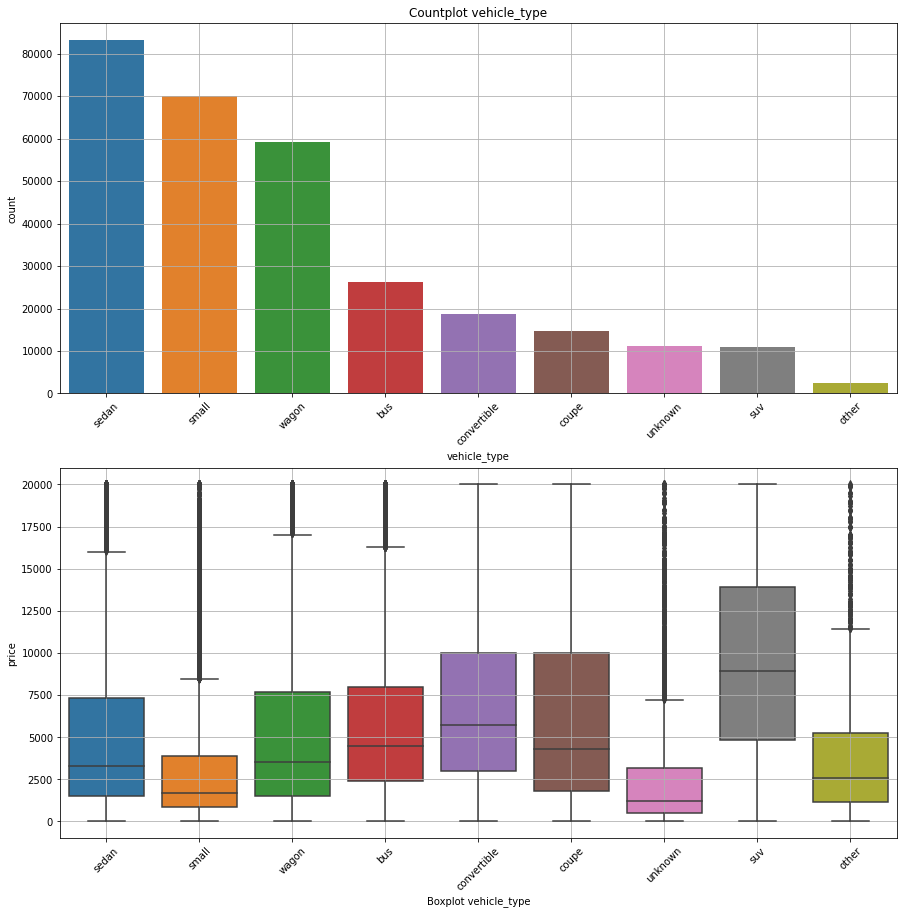

          count    percent
gearbox                   
manual   232285  78.308257
auto      58953  19.874321
unknown    5391   1.817422


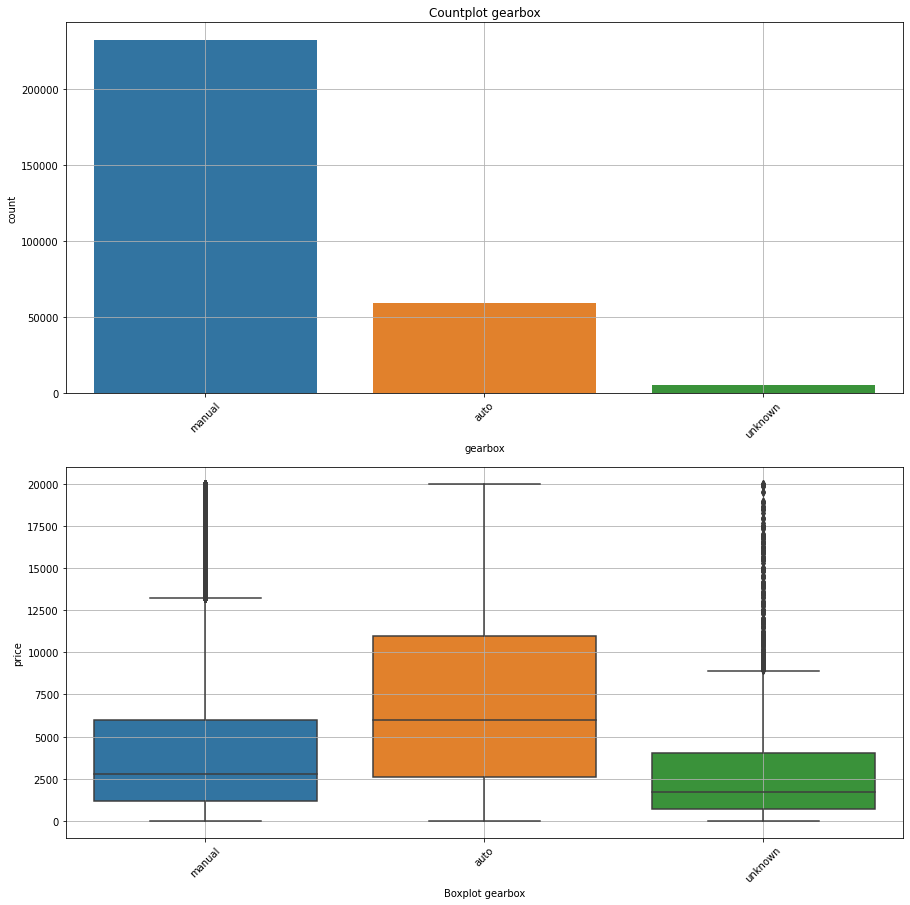

                    count   percent
model                              
golf                24730  8.337014
other               20464  6.898853
3er                 17388  5.861868
unknown             11209  3.778794
polo                10696  3.605851
...                   ...       ...
serie_2                 5  0.001686
samara                  5  0.001686
serie_3                 3  0.001011
range_rover_evoque      2  0.000674
rangerover              2  0.000674

[250 rows x 2 columns]


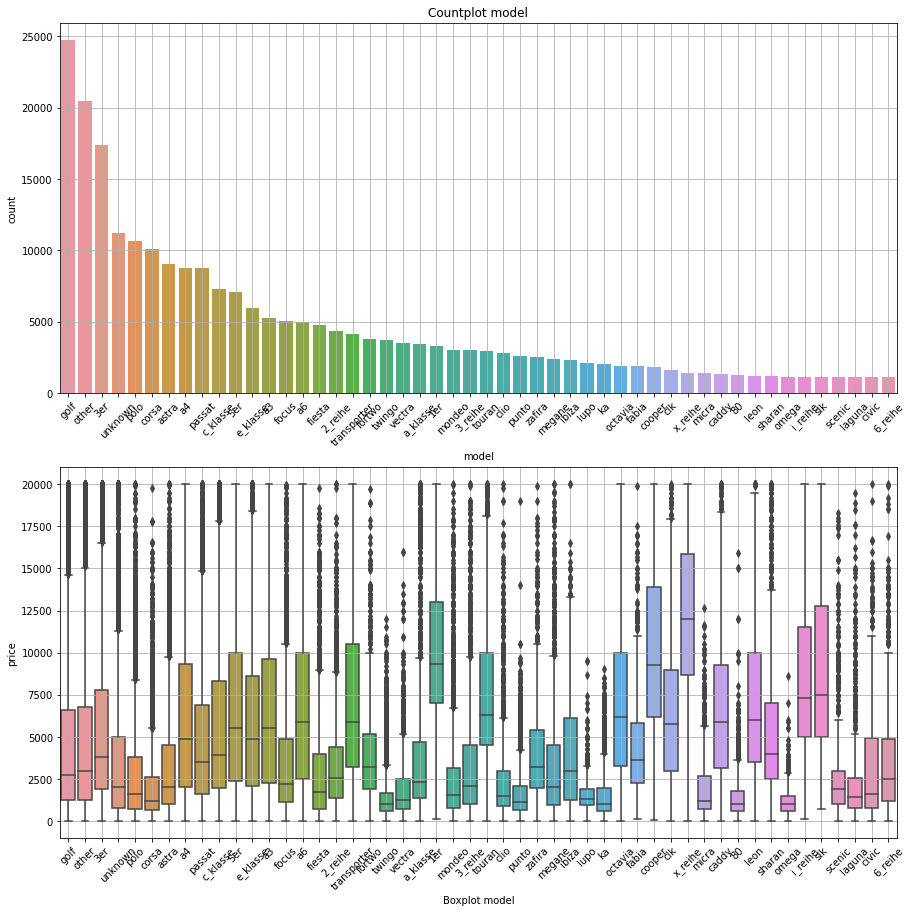

            count    percent
fuel_type                   
petrol     187632  63.254773
gasoline    87863  29.620502
unknown     15593   5.256735
lpg          4687   1.580088
cng           483   0.162830
hybrid        202   0.068099
other          93   0.031352
electric       76   0.025621


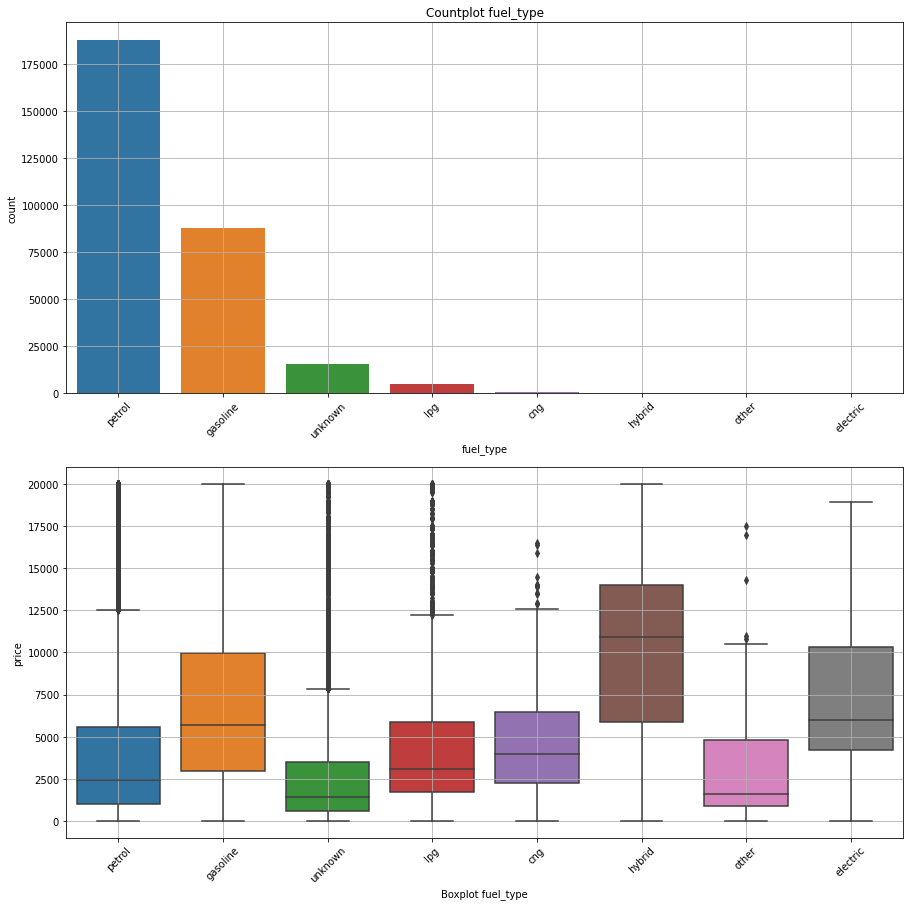

                count    percent
brand                           
volkswagen      64128  21.618925
opel            32548  10.972629
bmw             32284  10.883629
mercedes_benz   27348   9.219598
audi            25642   8.644468
ford            20728   6.987854
renault         13951   4.703181
peugeot          9424   3.177033
fiat             7687   2.591453
seat             5862   1.976206
skoda            4949   1.668414
mazda            4727   1.593573
smart            4487   1.512664
citroen          4259   1.435800
nissan           4048   1.364668
toyota           4014   1.353206
hyundai          3110   1.048448
mini             2965   0.999565
volvo            2825   0.952368
mitsubishi       2499   0.842467
honda            2366   0.797629
kia              2088   0.703910
alfa_romeo       1981   0.667838
suzuki           1965   0.662444
sonstige_autos   1850   0.623675
chevrolet        1464   0.493546
chrysler         1169   0.394095
dacia             801   0.270034
subaru    

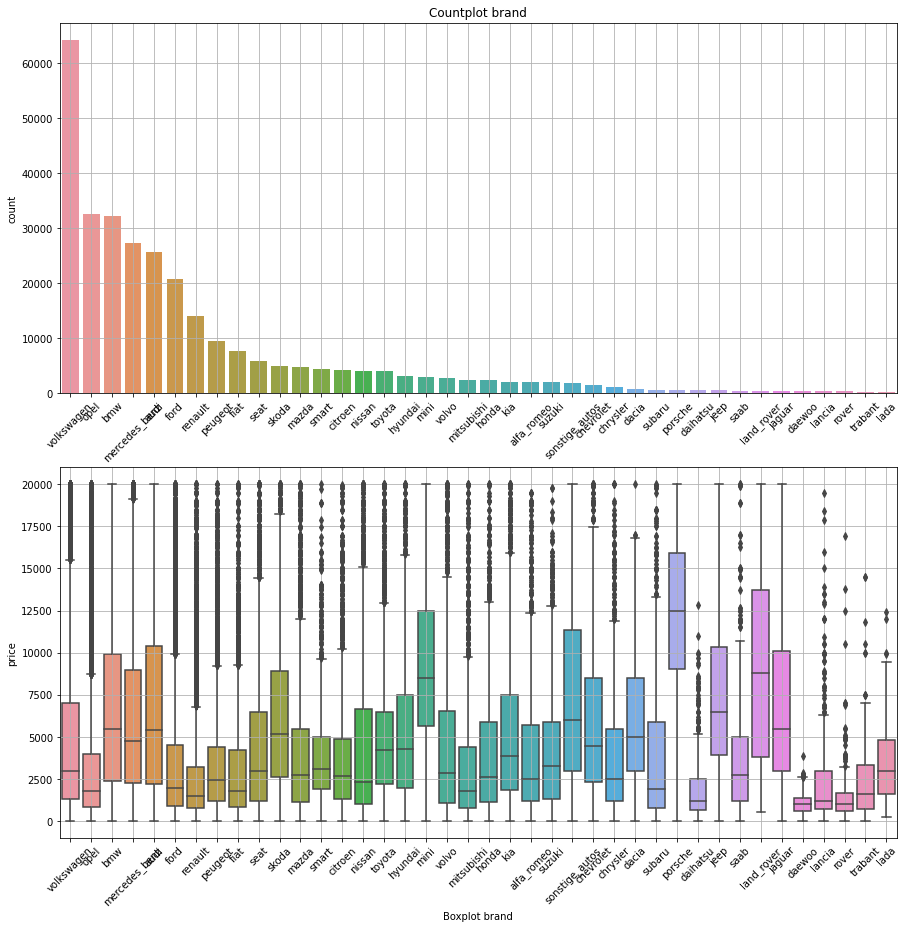

               count    percent
not_repaired                   
no            224697  75.750180
unknown        42979  14.489143
yes            28953   9.760677


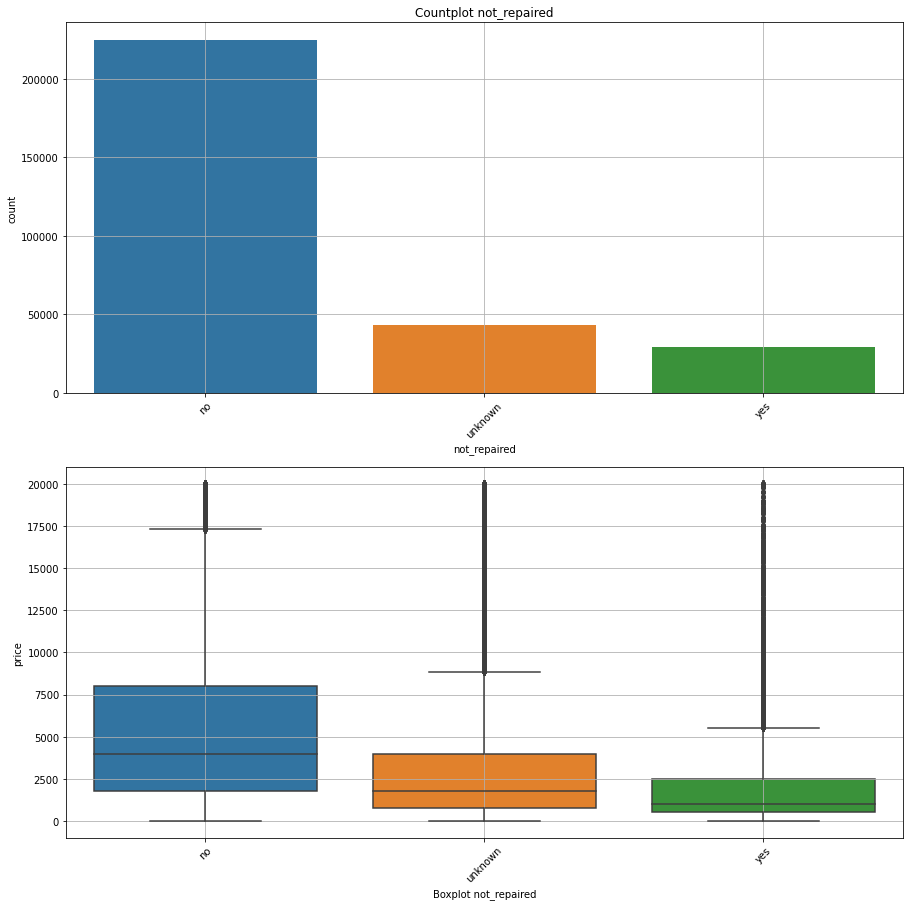

In [26]:
df_temp = df.fillna('unknown')

for col in df_temp.select_dtypes(include='object').columns:
    plt.figure(figsize=(15,15))
    plt.subplot(2,1,1)
    print(df_temp.groupby(col)[col].agg(['count']).assign(percent=lambda x: x / x.sum() * 100).
                                    sort_values('count', ascending=False))
    sns.countplot(data = df_temp, x = col, order = df_temp[col].value_counts().index[:50])
    plt.grid()
    plt.title('Countplot '+col)
    plt.xticks(rotation=45)
    plt.subplot(2,1,2)
    sns.boxplot(data = df_temp, x = col, y='price', order = df_temp[col].value_counts().index[:50])
    plt.grid()
    plt.xticks(rotation=45)
    plt.xlabel('Boxplot '+col)

    plt.show()
    

Наиболее популярным типом кузова являются `sedan`(25%) и `small`(22%). Наиболее дорогим кузовом является `suv`, самая низкая средняя цена у кузовов типов `small`, `unknown` и `other`. Характер боксплота типов `unknown` и `other` имеет схожий вид. С учетом того, что смысловое содержание этих типов также достаточно схоже, возможно, имеет смысл объединить их в одну группу и заменить пропуски на тип 'other'.  
Тип коробки передач в 76% случаев относиться к `manual` и в 19% к `auto`. Пропущенные значения `unknown` в данном столбце составляют около 6% данных, исходя из вида боксплота в основном пропущенные значения относятся к типу `manual` и могут быть заменены на этот тип.  
Самые популярные модели c охватом более 5% датасета - `golf` (8,2%) и `3er`(5,6%), самая популярная марка с достаточно высоким отрывом от конкурентов - `volkswagen` (21%).  
61% автомобилей относятся к типу топлива `petrol`, 28%  - `gasoline`. Доля остальных типов незначительна. По данному признаку тип `unknown` и `other` имеют достаточно схожее распределение по отношению к цене и могут быть объединены.  
70% машин не были в ремонте и 10% ремонтировались. Данный признак содержит около 20% пропущенных значений. На основе сопоставления с характером распределения пропущенные значения по данному параметру наиболее логично заменить на `yes`, т.е. побывавшие в ремонте.

Произведем соответствующие замены пропущенных значений.

In [27]:
df = df.fillna({'vehicle_type':'other', 
                'gearbox':'manual',
                'model':'unknown',
                'fuel_type':'other',
                'not_repaired':'yes'})

Оставим в датасете только нужные столбцы

In [28]:
df = df[['price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired']]

Заменим бинарные категориальные признаки `gearbox` и `not_repaired` на булев тип

In [29]:
df['is_manual_gearbox'] = df['gearbox'].map({'manual':1, 'auto':0})
df['is_not_repaired'] = df['not_repaired'].map({'yes':1, 'no':0})
df.drop(['gearbox', 'not_repaired'], axis=1, inplace=True)

Уменьшим размерность хранения числовых типов данных для ускорения работы с данными.

In [30]:
num_columns = df.select_dtypes(include='number').columns
for col in num_columns:
    df[col]= pd.to_numeric(df[col], downcast='integer')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296629 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               296629 non-null  int16 
 1   vehicle_type        296629 non-null  object
 2   registration_year   296629 non-null  int16 
 3   power               296629 non-null  int16 
 4   model               296629 non-null  object
 5   kilometer           296629 non-null  int32 
 6   registration_month  296629 non-null  int8  
 7   fuel_type           296629 non-null  object
 8   brand               296629 non-null  object
 9   is_manual_gearbox   296629 non-null  int8  
 10  is_not_repaired     296629 non-null  int8  
dtypes: int16(3), int32(1), int8(3), object(4)
memory usage: 23.1+ MB


Выделим предикторы и целевой признак

In [32]:
X = df.drop('price', axis=1)
y = df.price

Произведем кодировку категориальных признаков несколькими способами:
- Изменение типа на `category` для работы с моделями Catboost и lightGBM (`cat`).
- Кодировка методом OHE (`ohe`).
- Кодировка методом OE (`ord`).

In [33]:
categ_columns = X.select_dtypes(include='object').columns

In [34]:
# Изменение типа на 'category'
X_cat = X.copy()
X_cat[categ_columns] = X_cat[categ_columns].astype('category')
X_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296629 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   vehicle_type        296629 non-null  category
 1   registration_year   296629 non-null  int16   
 2   power               296629 non-null  int16   
 3   model               296629 non-null  category
 4   kilometer           296629 non-null  int32   
 5   registration_month  296629 non-null  int8    
 6   fuel_type           296629 non-null  category
 7   brand               296629 non-null  category
 8   is_manual_gearbox   296629 non-null  int8    
 9   is_not_repaired     296629 non-null  int8    
dtypes: category(4), int16(2), int32(1), int8(3)
memory usage: 14.9 MB


In [35]:
# Кодировка методом One Hot Encoding
X_ohe = pd.get_dummies(X, drop_first=True)
X_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296629 entries, 1 to 354368
Columns: 307 entries, registration_year to brand_volvo
dtypes: int16(2), int32(1), int8(3), uint8(301)
memory usage: 98.6 MB


In [36]:
# Кодировка методом Ordinal Encoding
enc = OrdinalEncoder()

X_ord = X.copy()
X_ord[categ_columns] = enc.fit_transform(X_ord[categ_columns])
X_ord.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296629 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   vehicle_type        296629 non-null  float64
 1   registration_year   296629 non-null  int16  
 2   power               296629 non-null  int16  
 3   model               296629 non-null  float64
 4   kilometer           296629 non-null  int32  
 5   registration_month  296629 non-null  int8   
 6   fuel_type           296629 non-null  float64
 7   brand               296629 non-null  float64
 8   is_manual_gearbox   296629 non-null  int8   
 9   is_not_repaired     296629 non-null  int8   
dtypes: float64(4), int16(2), int32(1), int8(3)
memory usage: 22.5 MB


Разделим данные на обучающую и тестовую выборки, согласно условию в тестовую выборку включим 10% данных

In [37]:
y_train, y_test = train_test_split(y, test_size=0.1, random_state=555)
y_train.shape[0] / y_test.shape[0]

8.999966287968176

In [38]:
X_cat_train, X_cat_test = train_test_split(X_cat, test_size=0.1, random_state=555)
X_ohe_train, X_ohe_test = train_test_split(X_ohe, test_size=0.1, random_state=555)
X_ord_train, X_ord_test = train_test_split(X_ord, test_size=0.1, random_state=555)

Подготовим также набор масштабированных данных

In [39]:
scaler = MinMaxScaler()

scaler.fit(X_ohe_train)
X_ohe_scal_train = pd.DataFrame(scaler.transform(X_ohe_train), columns=X_ohe_train.columns, index=X_ohe_train.index)
X_ohe_scal_test = pd.DataFrame(scaler.transform(X_ohe_test), columns=X_ohe_test.columns, index=X_ohe_test.index)

In [40]:
scaler.fit(X_ord_train)
X_ord_scal_train = pd.DataFrame(scaler.transform(X_ord_train), columns=X_ord_train.columns, index=X_ord_train.index)
X_ord_scal_test = pd.DataFrame(scaler.transform(X_ord_test), columns=X_ord_test.columns, index=X_ord_test.index)

## Обучение моделей

Исследуем модели Линейной Регрессии, Случайного Леса и Градиентного Бустинга:
 * LinearRegression
 * RandomForestRegressor
 * CatBoostRegressor
 * LGBMRegressor

Метрикой качества моделей является RMSE. Качество моделей будем проверять на кросс-валидации.

Для проверки адекватности моделей машинного обучения, оценим метрику RMSE для константной модели, делающей прогнозы на основе среднего значения по обучающей выборки.

In [41]:
# RMSE константной модели для обучающей выборки
mean_squared_error(y_train, pd.Series(y_train.mean(), index=y_train.index)) ** 0.5

4614.172794376439

In [42]:
# RMSE константной модели для тестовой выборки
mean_squared_error(y_test, pd.Series(y_train.mean(), index=y_test.index)) ** 0.5

4593.9423832273005

### Линейная Регрессия

Начнем с Линейной Регрессии

In [43]:
%%time

lr_ohe = LinearRegression()
rmse_lr_ohe = (cross_val_score(estimator=lr_ohe, 
                             X=X_ohe_train, 
                             y=y_train, 
                             cv=5,
                             #n_jobs=-1, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE Модели Линейной Регрессии (кодировка OHE) =', rmse_lr_ohe)

RMSE Модели Линейной Регрессии (кодировка OHE) = 2626.376430242584
CPU times: total: 1min 4s
Wall time: 25.6 s


In [44]:
%%time

lr_ord = LinearRegression()
rmse_lr_ord = (cross_val_score(estimator=lr_ord, 
                             X=X_ord_train, 
                             y=y_train, 
                             cv=5,
                             #n_jobs=-1, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE Модели Линейной Регрессии (кодировка OrdinalEncoding) =', rmse_lr_ord)

RMSE Модели Линейной Регрессии (кодировка OrdinalEncoding) = 2975.1546630746107
CPU times: total: 422 ms
Wall time: 415 ms


Качество Линейной Модели на данных, обработанных методом OHE по метрике RMSE выше, чем по методу OrdinalEncoding. В то же время обучение потребовало значительно больше времени.

In [45]:
%%time

lr_ord_scal = LinearRegression()
rmse_lr_ord_scal = (cross_val_score(estimator=lr_ord_scal, 
                             X=X_ord_scal_train, 
                             y=y_train, 
                             cv=5,
                             #n_jobs=-1, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE Модели Линейной Регрессии (кодировка OrdinalEncoding с масштабированием) =', rmse_lr_ord_scal)

RMSE Модели Линейной Регрессии (кодировка OrdinalEncoding с масштабированием) = 2975.154663074606
CPU times: total: 359 ms
Wall time: 366 ms


Масштабирование не оказывает влияния на качество модели Линейной Регрессии, однако позволяет оценить важность признаков на основе коэффициентов уравнения регрессии.

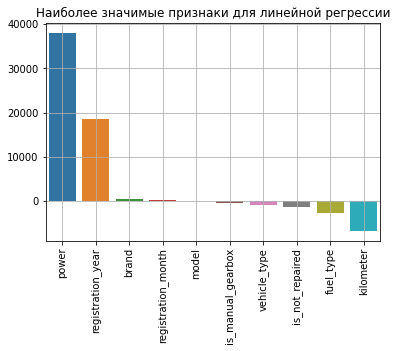

In [46]:
feat_importances = pd.Series(lr_ord_scal.fit(X_ord_scal_train, y_train).coef_, 
                                index=X_ord_scal_train.columns).sort_values(ascending=False)
sns.barplot(x=feat_importances.index, y=feat_importances.values)
plt.grid()
plt.title('Наиболее значимые признаки для линейной регрессии')
plt.xticks(rotation=90);

Наиболее важным признаком оказалась мощность двигателя, далее следуют год регистрации и пробег автомобиля.

### Случайный Лес

Исследуем модель Случайного Леса для варианта с кодировками OrdinalEncoding и подберем гиперпараметры

In [47]:
n_estimators = list(range(40, 121, 40))
max_depth = list(range(10, 41, 10))

hyperparams_rfr = {'n_estimators':n_estimators,
                'max_depth':max_depth,
                'random_state':[555]}

In [48]:
%%time

rfr_ord = GridSearchCV(estimator = RandomForestRegressor(), 
                        param_grid = hyperparams_rfr, 
                        scoring='neg_mean_squared_error',
                        cv=3,
                        n_jobs = -1)
rfr_ord.fit(X_ord_train, y_train)

CPU times: total: 1min 26s
Wall time: 13min 48s


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40],
                         'n_estimators': [40, 80, 120], 'random_state': [555]},
             scoring='neg_mean_squared_error')

In [49]:
rfr_ord_best_score = (rfr_ord.best_score_*-1) ** 0.5
print('RMSE Модели Случайного Леса (кодировка OrdinalEncoding) =', rfr_ord_best_score)


RMSE Модели Случайного Леса (кодировка OrdinalEncoding) = 1613.4279958902737


In [50]:
rfr_ord.best_params_

{'max_depth': 20, 'n_estimators': 120, 'random_state': 555}

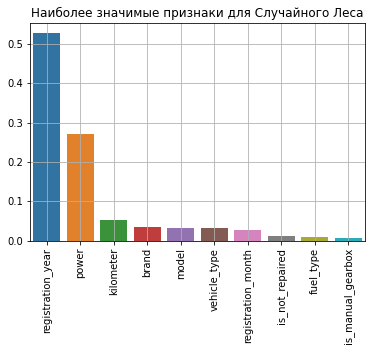

In [51]:
feat_importances = pd.Series(rfr_ord.best_estimator_.feature_importances_, 
                                        index=X_ord_scal_train.columns).sort_values(ascending=False)
sns.barplot(x=feat_importances.index, y=feat_importances.values)
plt.grid()
plt.title('Наиболее значимые признаки для Случайного Леса')
plt.xticks(rotation=90);

Для модели Случайного Леса топ-3 наиболее важных признаков такой же как и для Линейной Регрессии, однако год регистрации оказался важнее мощности двигателя.

В связи с длительностью расчетов модели Случайного Леса на данных обработанных методом OHE, произведем расчет этих данных только для набора гиперпараметров, подобранных на данных, подготовленны методом OrdinalEncoding

In [52]:
%%time

rfr_ohe = RandomForestRegressor(**rfr_ord.best_params_)
rmse_rfr_ohe = (cross_val_score(estimator=rfr_ohe, 
                             X=X_ohe_train, 
                             y=y_train, 
                             cv=3,
                             n_jobs=-1, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE Модели Случайного Леса (кодировка OHE) =', rmse_rfr_ohe)

RMSE Модели Случайного Леса (кодировка OHE) = 1621.8035401612067
CPU times: total: 188 ms
Wall time: 10min 36s


Модели Случайного Леса по качеству превзошли Линейную регрессию. Кодировка методом OHE не дала прироста в качестве модели Случайного Леса. 

### Градиентный бустинг (библиотека CatBoost)

In [53]:
%%time

cbr = CatBoostRegressor(cat_features=categ_columns.tolist())
hyperparams_cbr = { 'depth'         : [10, 20, 30],
                    'iterations'    : [100, 200, 300],
                    'random_state'  : [555],
                    'verbose'       : [False]
                  }
cbr_grid = GridSearchCV(estimator=cbr, 
                        param_grid = hyperparams_cbr, 
                        cv = 3, 
                        scoring ='neg_mean_squared_error',
                        n_jobs=-1)
cbr_grid.fit(X_cat_train, y_train) 

CPU times: total: 5min 44s
Wall time: 7min 47s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001C8B7751790>,
             n_jobs=-1,
             param_grid={'depth': [10, 20, 30], 'iterations': [100, 200, 300],
                         'random_state': [555], 'verbose': [False]},
             scoring='neg_mean_squared_error')

In [54]:
cbr_grid.best_params_

{'depth': 10, 'iterations': 300, 'random_state': 555, 'verbose': False}

In [55]:
rmse_cbr = (cbr_grid.best_score_*-1) ** 0.5
print('RMSE Модели Градиентного Бустинга (CatBoost) =', rmse_cbr) 

RMSE Модели Градиентного Бустинга (CatBoost) = 1576.2500993101598


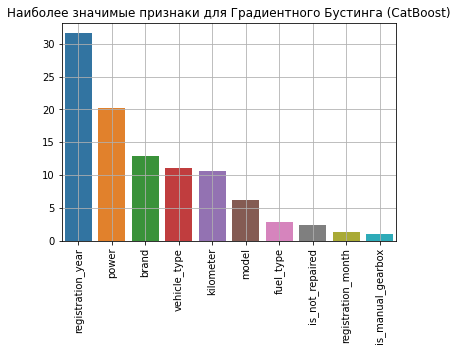

In [56]:
feat_importances = pd.Series(cbr_grid.best_estimator_.feature_importances_, 
                                        index=X_ord_scal_train.columns).sort_values(ascending=False)
sns.barplot(x=feat_importances.index, y=feat_importances.values)
plt.grid()
plt.title('Наиболее значимые признаки для Градиентного Бустинга (CatBoost)')
plt.xticks(rotation=90);

Качество модели Градиентного Бустинга оказалось выше Линейной Регрессии и нескольку лучше Случайного Леса. Год регистрации и мощность двигателя также в списке наиболее важных признаков. Для Градиентного бустинга важными оказались также марка автомобиля и тип кузова, а пробег сместился на пятое месте.

### Градиентный бустинг (библиотека LightGBM )

Для библиотеки LightGBM произведем перебор аналогичных гиперпараметров

In [57]:
%%time

lgbmr = LGBMRegressor(categorical_features=categ_columns.tolist())
hyperparams_lgbmr = { 'max_depth'     : [10, 20, 30],
                      'n_estimators'  : [100, 200, 300],
                      'random_state'  : [555]
                  }
lgbmr_grid = GridSearchCV(estimator=lgbmr, 
                        param_grid = hyperparams_lgbmr, 
                        cv = 3, 
                        scoring ='neg_mean_squared_error',
                        n_jobs=-1)
lgbmr_grid.fit(X_cat_train, y_train) 

CPU times: total: 9.58 s
Wall time: 50.6 s


GridSearchCV(cv=3,
             estimator=LGBMRegressor(categorical_features=['vehicle_type',
                                                           'model', 'fuel_type',
                                                           'brand']),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'n_estimators': [100, 200, 300],
                         'random_state': [555]},
             scoring='neg_mean_squared_error')

In [58]:
lgbmr_grid.best_params_

{'max_depth': 20, 'n_estimators': 300, 'random_state': 555}

In [59]:
rmse_lgbmr = (lgbmr_grid.best_score_*-1) ** 0.5
print('RMSE Модели Градиентного Бустинга (LightGBM) =', rmse_lgbmr) 

RMSE Модели Градиентного Бустинга (LightGBM) = 1582.5325751884873


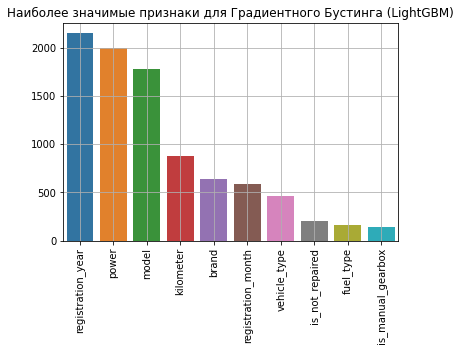

In [60]:
feat_importances = pd.Series(lgbmr_grid.best_estimator_.feature_importances_, 
                                        index=X_ord_scal_train.columns).sort_values(ascending=False)
sns.barplot(x=feat_importances.index, y=feat_importances.values)
plt.grid()
plt.title('Наиболее значимые признаки для Градиентного Бустинга (LightGBM)')
plt.xticks(rotation=90);

Для LightGBM достаточно важным признаком кроме года регистрации и мощности и сопоставимым с ними по значимости оказалась еще модель автомобиля.

Модели Градиентного Бустинга показали схожее значение метрики RMSE на обучающих данных. Модель CatBoost дал несколько лучшее значение метрики, но длительность перебора одинакового количества гиперпараметров заняло у библиотеки LightGBM  существенно меньше времени.

## Анализ моделей

Для исследованных моделей произведем обучение на всем наборе обучающих данных на основе подобранных гиперппараметров, замерим длительность обучения и качество предсказания на тестовых данных

In [61]:
def model_result(model, X_train, X_test, y_train=y_train, y_test=y_test):
    '''
    Функция обучает модель на обучающем наборе данных,
    возвращает метрику качества rmse на тестовом наборе данных, время обучения и предсказания
    '''
    start1 = time.time()
    model.fit(X_train, y_train)
    end1 = time.time()
    time_train = end1 - start1

    start2 = time.time()
    y_pred = model.predict(X_test)
    end2 = time.time()
    time_predict = end2 - start2

    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    return round(rmse), round(time_train, 1), round(time_predict, 1)


In [62]:
# Linear (OrdinalEncoding)
lr_ord_result = model_result(lr_ord, X_train=X_ord_train, X_test=X_ord_test)
lr_ord_result

(2983, 0.1, 0.0)

In [63]:
# Linear (OHE)
lr_ohe_result = model_result(lr_ohe, X_train=X_ohe_train, X_test=X_ohe_test)
lr_ohe_result

(2628, 6.0, 0.1)

In [64]:
# RandomForest (OrdinalEncoding)
rfr_ord_result = model_result(rfr_ord.best_estimator_, X_train=X_ord_train, X_test=X_ord_test)
rfr_ord_result

(1567, 88.6, 1.1)

In [65]:
# RandomForest (OHE)
rfr_ohe_result = model_result(rfr_ohe, X_train=X_ohe_train, X_test=X_ohe_test)
rfr_ohe_result

(1583, 631.1, 1.1)

In [66]:
# CatBoost
cbr_result = model_result(cbr_grid.best_estimator_, X_train=X_cat_train, X_test=X_cat_test)
cbr_result

(1557, 104.5, 0.1)

In [67]:
# LightGBM
lgbmr_result = model_result(lgbmr_grid.best_estimator_, X_train=X_cat_train, X_test=X_cat_test)
lgbmr_result

(1577, 3.0, 0.3)

In [68]:
model_list = [lr_ord_result, lr_ohe_result, rfr_ord_result, rfr_ohe_result, cbr_result, lgbmr_result]
rmse_list = [model[0] for model in model_list]
time_train_list = [model[1] for model in model_list]
time_predict_list = [model[2] for model in model_list]
model_name_list = ['Linear (OrdinalEncoding)', 'Linear (OHE)', 'RandomForest (OrdinalEncoding)', 'RandomForest (OHE)', 
                                                                                        'CatBoost', 'LightGBM' ]

In [69]:
results_df = pd.DataFrame(data={'RMSE':rmse_list, 'Time_train':time_train_list, 'Time_predict':time_predict_list,},
                                                                                index=model_name_list)
results_df

,RMSE,Time_train,Time_predict
Linear (OrdinalEncoding),2983,0.1,0.0
Linear (OHE),2628,6.0,0.1
RandomForest (OrdinalEncoding),1567,88.6,1.1
RandomForest (OHE),1583,631.1,1.1
CatBoost,1557,104.5,0.1
LightGBM,1577,3.0,0.3


Из рассмотренных моделей, модели Случайного Леса и Градиентного Бустинга показали схожие значения метрики качества RMSE на тестовой выборке. При этом Случайный Лес с порядковым кодированием и Градиентный Бустинг с использованием библиотеки CatBoost показали примерно одинаковое время обучения. Метрика качестве rmse модели LightGBM хоть несколько хуже CatBoost и RandomForest, но время обучение меньше на порядок. С учетом соотношения качества модели и времени обучение можно признать для данного набора данных лучшей моделью - модель Градиентного бустинга в реализации LightGBM.

## Вывод

Проанализирован исторический набор данных по характеристикам автомобилей и их стоимости, произведена предобработка и разведывательный анализ данных (удалены дубликаты, заполнены пропуски, выявлены и удалены некорректные значения по ряду параметров, изменены типы данных, удалены ненужные для прогнозирования столбцы, визуализированы некоторые зависимости).  
Очищенный набор данных подготовлен для построения моделей машинного обучения - произведена кодировка категориальных признаков методами OrdinalEncoding и OneHotEncoding, разделение данных на обучающий и тестовый набор данных.  
Для прогнозирования стоимости были исследованы модели Линейоной Регрессии и Случайного Леса для разных вариантов кодировки категориальных признаков, а также Градиентного Бустинга в реализации библиотек CatBoost и LightGBM. Произведен подбор гиперпараметров для моделей Случайного Леса и Градиентного Бустинга на кросс-валидации.  
Наиболее важными признаками с точки зрения прогностической ценности для всех моделей являются год регистрации автомобиля и его мощность, пробег также имеет большое значение для всех моделей, для  моделей Градиентного Бустинга параметр пробега несколько уступает по важности другим признакам (марка и тип кузова для CatBoost, модель автомобиля для LightGBM).  
На основе подобранных гиперпараметров произведено обучение моделей на всем наборе обучающих данных, расчет метрики RMSE на тестовом наборе и расчет времени обучения и предсказания. Модели Линейной Регрессии характеризуются быстрым обучением, но низким качеством предсказания. Модели Градиентного Бустинга и Случайного Леса имеют примерно одинаковое качество (rmse=1557-1583 евро). Из них наименьшее время на обучение при заданных гиперпараметрах затрачивает модель Градиентного Бустинга библиотеки LightGBM и может быть признана наиболее оптимальным вариантом по соотношению качество-время обучения.  



## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей